# deriving speed curves

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style ppt.mplstyle'), line 10 ('font.size: 16')
Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style ppt.mplstyle'), line 25 ('lines.linewidth: 3')

Bad key text.fontsize in file C:\Users\Admin\Documents\Akseli\Code\ethograph\configs\style ppt.mplstyle, line 16 ('text.fontsize: 14')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.8/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


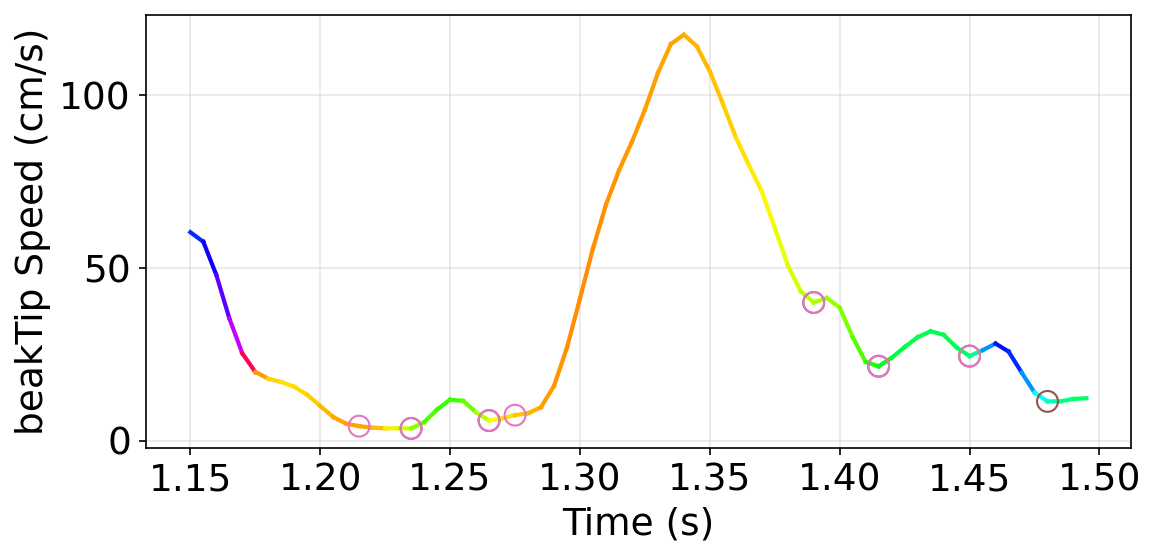

In [2]:
%load_ext autoreload
%autoreload 2

from ethograph.utils.io import TrialTree

from ethograph.utils.paths import get_project_root
from ethograph.plots.plot_plt import plot_ds_variable
import matplotlib.pyplot as plt


path = r"C:\Users\Admin\Documents\Akseli\Trial_data_Freddy_20250526_02.nc"
dt = TrialTree.load(path)


ds = dt.trial(141)

ds




style_sheet = get_project_root() / "configs" / "style ppt.mplstyle"
plt.style.use(style_sheet)

fig, ax = plt.subplots(figsize=(8, 4))

plot_ds_variable(
    ax,
    ds.isel(time=slice(230, 300)),
    {'keypoints': 'beakTip', 'individuals': 'Freddy'},
    'speed',
    'angle_rgb'
)
plt.ylabel('beakTip Speed (cm/s)')
plt.xlabel('Time (s)')
plt.title('')
plt.legend().remove()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

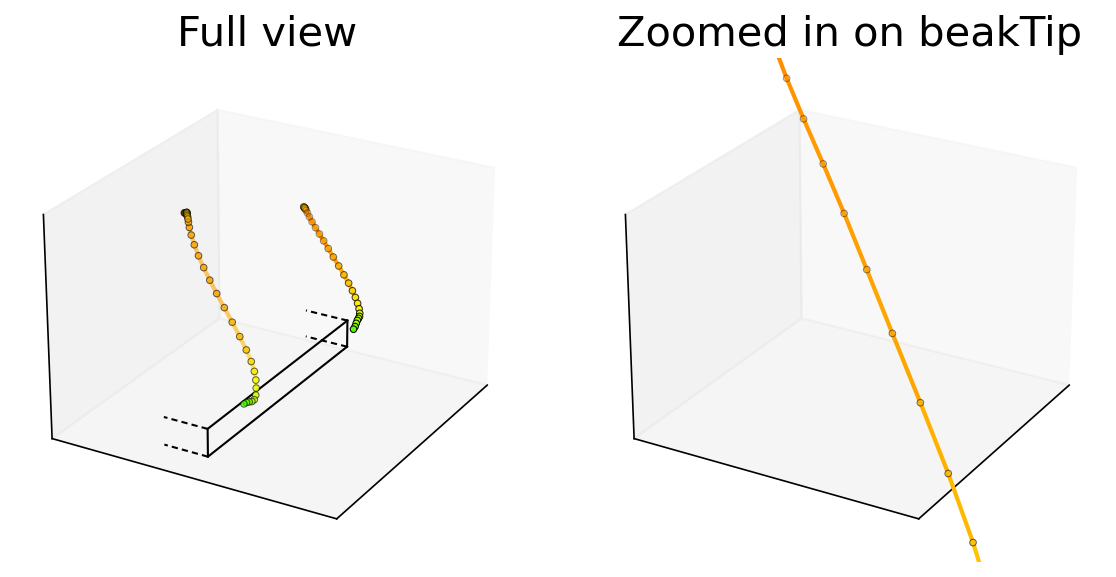

In [3]:
import numpy as np

time_slice = slice(248, 282)

pos_beak = ds.position.sel(keypoints='beakTip', individuals='Freddy').isel(time=time_slice)
X_beak = pos_beak.sel(space='x').values
Y_beak = pos_beak.sel(space='y').values
Z_beak = pos_beak.sel(space='z').values

pos_stick = ds.position.sel(keypoints='stickTip', individuals='Freddy').isel(time=time_slice)
X_stick = pos_stick.sel(space='x').values
Y_stick = pos_stick.sel(space='y').values
Z_stick = pos_stick.sel(space='z').values

color_data_beak = ds.angle_rgb.sel(keypoints='beakTip', individuals='Freddy').isel(time=time_slice).values
color_data_stick = ds.angle_rgb.sel(keypoints='stickTip', individuals='Freddy').isel(time=time_slice).values

if color_data_beak.max() > 1.0:
    color_data_beak = color_data_beak / 255.0
if color_data_stick.max() > 1.0:
    color_data_stick = color_data_stick / 255.0

box_xy_base = np.array([
    [-7.00,  0.00],
    [-7.00,  9.80],
    [ 6.80,  9.80],
    [ 6.80,  0.00]
])
z_bot, z_top = 0.65, 2.75

x_min, x_max = box_xy_base[:, 0].min(), box_xy_base[:, 0].max()
y_min, y_max = box_xy_base[:, 1].min(), box_xy_base[:, 1].max()

vertices = np.array([
    [x_min, y_min, z_bot],
    [x_max, y_min, z_bot],
    [x_max, y_max, z_bot],
    [x_min, y_max, z_bot],
    [x_min, y_min, z_top],
    [x_max, y_min, z_top],
    [x_max, y_max, z_top],
    [x_min, y_max, z_top]
])

front_edges = [(0,1), (4,5), (0,4), (1,5)]
depth_edges = [(0,3), (1,2), (4,7), (5,6)]
depth_fraction = 1/5

# Compute centroid and zoom radius
centroid_x = np.nanmean(X_beak)
centroid_y = np.nanmean(Y_beak)
centroid_z = np.nanmean(Z_beak)
zoom_radius = 1  # Adjust this to control zoom level

fig = plt.figure(figsize=(8, 4))

def draw_scene(ax):
    for v1, v2 in front_edges:
        p1, p2 = vertices[v1], vertices[v2]
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], [p1[2], p2[2]], 'k-', linewidth=1)
    
    for v1, v2 in depth_edges:
        p1, p2 = vertices[v1], vertices[v2]
        p_end = p1 + depth_fraction * (p2 - p1)
        ax.plot([p1[0], p_end[0]], [p1[1], p_end[1]], [p1[2], p_end[2]],
                'k--', linewidth=1, dashes=(3, 2))
    
    for i in range(len(X_beak) - 1):
        ax.plot(X_beak[i:i+2], Y_beak[i:i+2], Z_beak[i:i+2], color=color_data_beak[i], linewidth=2)
    ax.scatter(X_beak, Y_beak, Z_beak, c=color_data_beak, s=10, edgecolors='k', linewidths=0.5, zorder=5)
    
    for i in range(len(X_stick) - 1):
        ax.plot(X_stick[i:i+2], Y_stick[i:i+2], Z_stick[i:i+2], color=color_data_stick[i], linewidth=2, alpha=0.6)
    ax.scatter(X_stick, Y_stick, Z_stick, c=color_data_stick, s=10, edgecolors='k', linewidths=0.5, zorder=5, alpha=0.6)

# Left: full view
ax1 = fig.add_subplot(121, projection='3d')
draw_scene(ax1)
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_zlabel('')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_zticks([])
ax1.set_title('Full view')
ax1.view_init(elev=25, azim=210)

# Right: zoomed view
ax2 = fig.add_subplot(122, projection='3d')
draw_scene(ax2)
ax2.set_xlim(centroid_x - zoom_radius, centroid_x + zoom_radius)
ax2.set_ylim(centroid_y - zoom_radius, centroid_y + zoom_radius)
ax2.set_zlim(centroid_z - zoom_radius, centroid_z + zoom_radius)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_zlabel('')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_zticks([])
ax2.set_title('Zoomed in on beakTip')
ax2.view_init(elev=25, azim=210)

plt.tight_layout()
plt.show()

# syllable length variability

In [2]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
from ethograph.utils.io import TrialTree
import xarray as xr
from typing import Dict, List
import matplotlib.pyplot as plt
from ethograph.utils.data_utils import ds_to_df, stack_trials
from ethograph.features.mov_features import create_heatmap_from_segments
from ethograph.utils.paths import get_project_root
from ethograph.utils.data_utils import build_angle_rgb_dict, build_speed_dict
from ethograph.utils.io import TrialTree

import pandas as pd



paths = [r"D:\sub-03_id-Freddy\ses-000_date-20250526_01\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250526_02\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250527_01\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250527_02\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250528_01\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250528_02\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250529_01\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250530_01\behav\Trial_data.nc",
         r"D:\sub-03_id-Freddy\ses-000_date-20250602_01\behav\Trial_data.nc"]
         
         
        
temp_path = get_project_root() / "data" / "temp"

# Load and stack
trees = {f"tree_{i}": TrialTree.load(p) for i, p in enumerate(paths)}
# ds = stack_trials(trees, ["labels", "angle_rgb", "speed"], ["session", "trial", "poscat", "num_pellets"])
# df = ds_to_df(ds)
#df.to_pickle(temp_path / "df_syllable_variability.pkl")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_pickle(temp_path / "df_syllable_variability.pkl")

In [19]:
mappings

{0: {'name': 'background',
  'color': array([0.00392157, 0.00392157, 0.00392157])},
 1: {'name': 'pullOutStick',
  'color': array([1.        , 0.4       , 0.69803922])},
 2: {'name': 'diagonalToBox',
  'color': array([0.4       , 0.61960784, 1.        ])},
 3: {'name': 'toss', 'color': array([0.6, 0.2, 1. ])},
 4: {'name': 'swoopLeftToCorner', 'color': array([1. , 0.2, 0.2])},
 5: {'name': 'reachToWall', 'color': array([0.4, 1. , 0.4])},
 6: {'name': 'right', 'color': array([1. , 0.6, 0.4])},
 7: {'name': 'pullOutPellet', 'color': array([0. , 0.6, 0. ])},
 8: {'name': 'swoopOut', 'color': array([0.        , 0.        , 0.50196078])},
 9: {'name': 'stickToDisp', 'color': array([1., 1., 0.])},
 10: {'name': 'stickInDisp', 'color': array([0. , 0.8, 0.8])},
 11: {'name': 'rightToPellet',
  'color': array([0.50196078, 0.50196078, 0.        ])},
 12: {'name': 'snapPellet', 'color': array([1., 0., 1.])},
 13: {'name': 'eat', 'color': array([1.        , 0.64705882, 0.        ])},
 14: {'name':

In [28]:
from ethograph.utils.paths import get_project_root
from ethograph.utils.labels import load_motif_mapping
import pandas as pd

def mark_outliers(group):
    q1 = group['duration'].quantile(0.25)
    q3 = group['duration'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (group['duration'] < lower) | (group['duration'] > upper)


def plot_duration_boxplots(
    df: pd.DataFrame,
    mappings: dict,
    xlim: tuple[float, float] = (0, 2.5),
    figsize: tuple[float, float] = (12, 8)
) -> tuple[plt.Figure, plt.Axes]:
    
    df_outliers = df[df.groupby('label', group_keys=False).apply(mark_outliers)]
    label_to_name = {k: v['name'] for k, v in mappings.items()}
    
    order = sorted(df['label'].unique())
    palette = [mappings[l]['color'] for l in order]
    
    fig, ax = plt.subplots(figsize=figsize)

    sns.boxplot(
        data=df,
        x='duration',
        y='label',
        order=order,
        palette=palette,
        orient='h',
        ax=ax,
        showfliers=False
    )
    sns.stripplot(
        data=df_outliers,
        x='duration',
        y='label',
        order=order,
        orient='h',
        ax=ax,
        color='black',
        size=4,
        alpha=0.6,
        linewidth=0.5
    )

    ax.set_yticklabels([label_to_name[l] for l in order])

    ax.set_ylabel('')
    ax.set_xlabel('Syllable duration (s)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(left=False)
    ax.set_xlim(*xlim)

    plt.tight_layout()
    
    return fig, ax

Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style ppt.mplstyle'), line 10 ('font.size: 16')
Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style ppt.mplstyle'), line 25 ('lines.linewidth: 3')

Bad key text.fontsize in file C:\Users\Admin\Documents\Akseli\Code\ethograph\configs\style ppt.mplstyle, line 16 ('text.fontsize: 14')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.8/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution
2026-01-20 18:07:58.168 | WARNING  | pandas.core.groupby.groupby:apply:1832 - C:\Users\Admin\AppData\Local\Temp\ipykernel_26756\1511805683.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the g

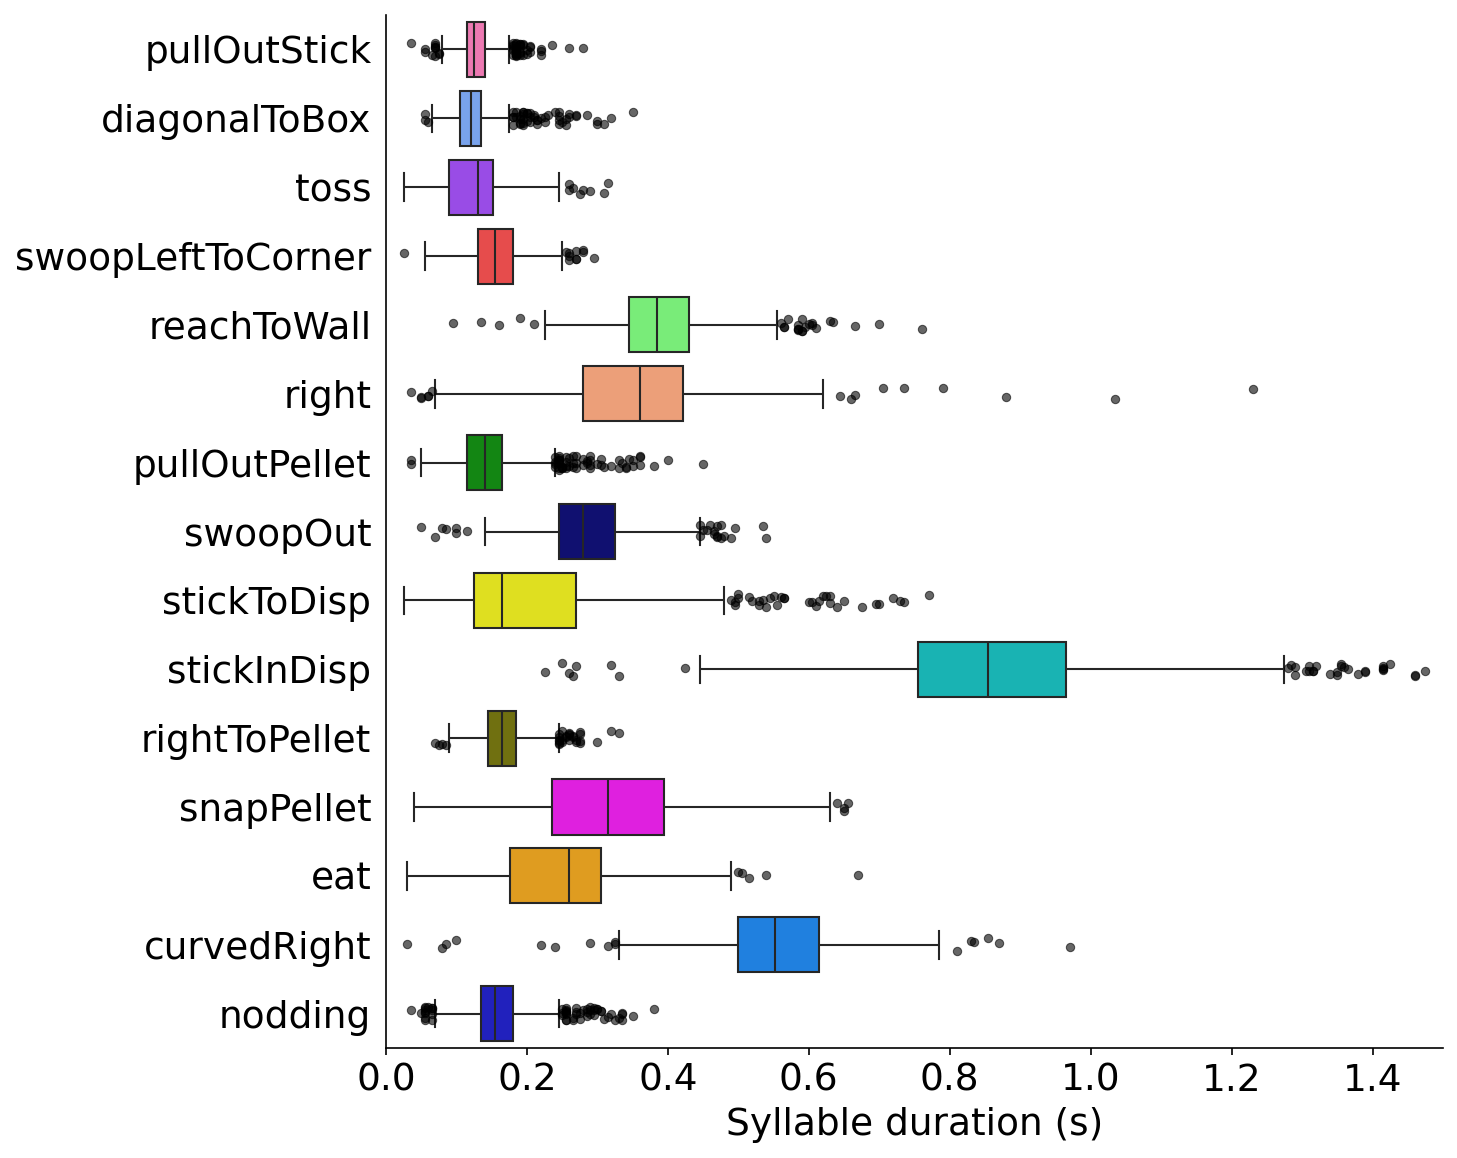

In [63]:


mapping_path =  get_project_root() / "configs" / "mapping.txt"
mappings = load_motif_mapping(mapping_path)
style_sheet = get_project_root() / "configs" / "style ppt.mplstyle"
plt.style.use(style_sheet)

# df_train = df.copy(deep=True)
# df_test = df.copy(deep=True)
# df_train = df_train[df_train['session'].isin(['2025-05-27_01', '2025-05-27_02', '2025-05-26_01', '2025-05-28_01'])]
# df_test = df_test[df_test['session'].isin(['2025-05-26_02', '2025-05-28_02', '2025-05-29_01', '2025-05-30_01', '2025-06-02_01'])]


label_long = 10


fig, ax = plot_duration_boxplots(
    df,
    mappings,
    xlim=(0, 1.5),
    figsize=(10, 8)
)


In [ ]:


# Build angle_rgb dict from pre-computed data
rgb_dict = build_angle_rgb_dict(trees, keypoint="beakTip", individual="Freddy")
rgb_dict

speed_dict = build_speed_dict(trees, keypoint="beakTip", individual="Freddy")
speed_dict 

Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style ppt.mplstyle'), line 10 ('font.size: 16')
Duplicate key in file WindowsPath('C:/Users/Admin/Documents/Akseli/Code/ethograph/configs/style ppt.mplstyle'), line 25 ('lines.linewidth: 3')

Bad key text.fontsize in file C:\Users\Admin\Documents\Akseli\Code\ethograph\configs\style ppt.mplstyle, line 16 ('text.fontsize: 14')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.10.8/lib/matplotlib/mpl-data/matplotlibrc
or from the matplotlib source distribution


Creating heatmap...
Data shape: (2153612,), Number of events: 1955


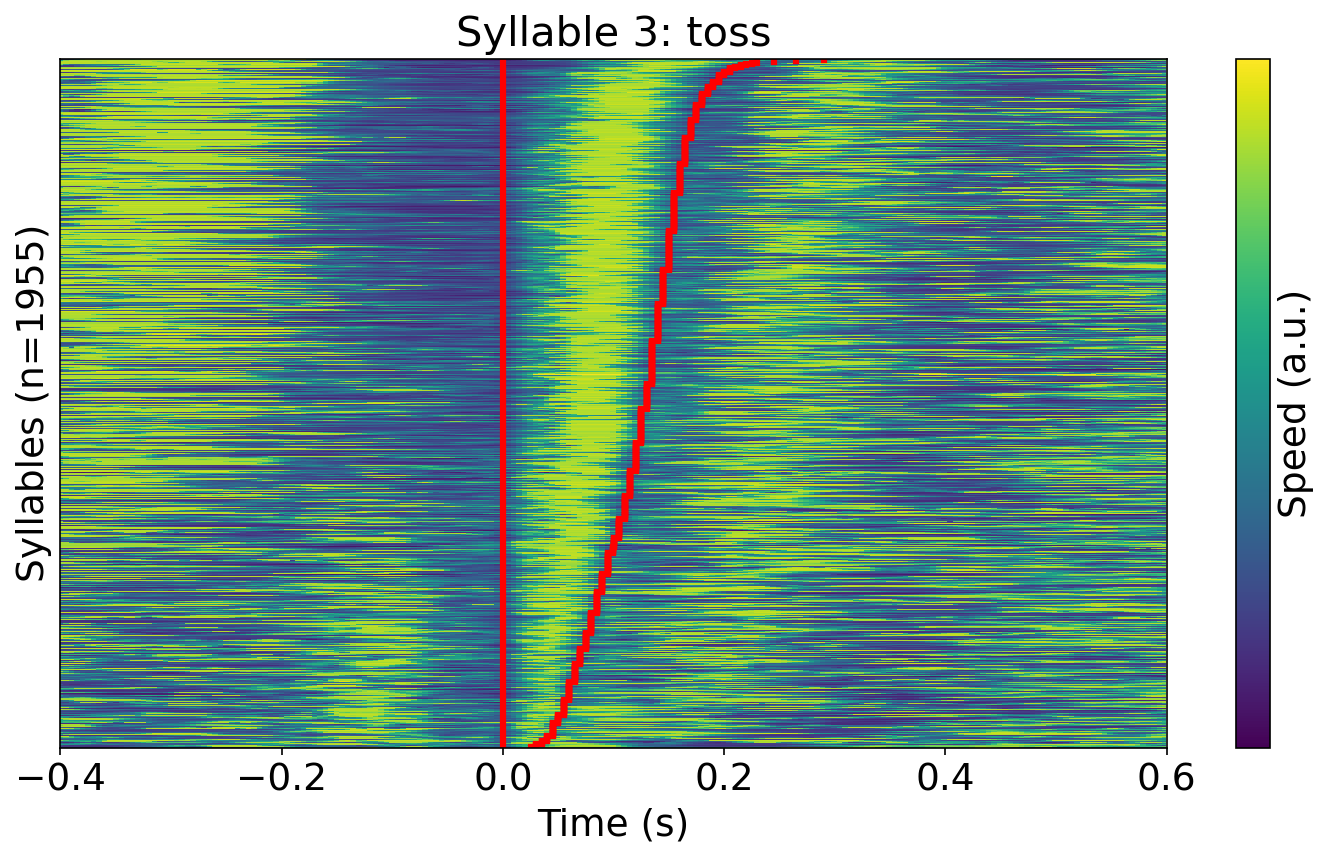

In [73]:
from ethograph.features.mov_features import create_heatmap_from_segments
from ethograph.utils.paths import get_project_root
from ethograph.utils.labels import load_mapping

style_sheet = get_project_root() / "configs" / "style ppt.mplstyle"
plt.style.use(style_sheet)

label = 3

mapping_path =  get_project_root() / "configs" / "mapping.txt"
_, mappings = load_mapping(mapping_path)
label_name = mappings[label]

# Create heatmap
fig, ax, data = create_heatmap_from_segments(
    df,
    speed_dict,
    fs=200.0,
    label_filter=label,
    window=2, 
    align_to='start',
    sort_by='duration',
)
ax.set_title(f"Syllable {label}: {label_name}")
ax.set_xlim(-0.4, 0.6)
cbar = plt.colorbar(ax.images[0], ax=ax, label='Speed (a.u.)')
cbar.ax.set_xticks([])
cbar.ax.set_yticks([])
plt.tight_layout()
plt.show()
